Import Libs and Dependencies

In [11]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

#settings
pd.set_option('display.max_rows', None)

Import keys from Envs

In [12]:
load_dotenv()

True

## Read in Alpaca Stock Data

In [13]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object\n",
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

# Format current date as ISO format
today = pd.Timestamp("2021-03-01", tz="America/New_York").isoformat()
start = pd.Timestamp("2020-03-01", tz="America/New_York").isoformat()

# today = date.today()
# start = today - timedelta(days=180)
# today = pd.Timestamp(today, tz="America/New_York").isoformat()
# start = pd.Timestamp(start, tz="America/New_York").isoformat()

print(f"Today = {today} and Start = {start}")

# Set the tickers\n",
tickers = ["FB"]

#timeframe
timeframe = "1D"

# Get current price data for MSFT and AAPL
df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = today,
    limit=1000
).df

# Display data
df.head()

Today = 2021-03-01T00:00:00-05:00 and Start = 2020-03-01T00:00:00-05:00


FB                                    
                             open    high       low   close    volume
time                                                                 
2020-03-02 00:00:00-05:00  194.10  196.57  188.8500  196.54  21795546
2020-03-03 00:00:00-05:00  196.22  197.24  183.9700  185.89  24693345
2020-03-04 00:00:00-05:00  189.05  191.83  186.3900  191.79  20486825
2020-03-05 00:00:00-05:00  186.78  188.99  183.8901  185.02  21975861
2020-03-06 00:00:00-05:00  178.33  183.78  176.2600  181.11  21916170

## Adjust cols and add returns

In [14]:
#drop the multi-index
df.columns = df.columns.get_level_values(1)

In [15]:
#add Returns
df['daily_return'] = df['close'].dropna().pct_change()
df.head()

,open,high,low,close,volume,daily_return
time,,,,,,
2020-03-02 00:00:00-05:00,194.10,196.57,188.8500,196.54,21795546,NaN
2020-03-03 00:00:00-05:00,196.22,197.24,183.9700,185.89,24693345,-0.054187
2020-03-04 00:00:00-05:00,189.05,191.83,186.3900,191.79,20486825,0.031739
2020-03-05 00:00:00-05:00,186.78,188.99,183.8901,185.02,21975861,-0.035299
2020-03-06 00:00:00-05:00,178.33,183.78,176.2600,181.11,21916170,-0.021133


## Construct EMA on Avg Closing Prices

In [16]:
short_window = 1
long_window = 5

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_close'] = df['close'].ewm(halflife=short_window).mean()
df['slow_close'] = df['close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df['crossover_long'] = np.where(df['fast_close'] > df['slow_close'], 1.0, 0.0)
df['crossover_short'] = np.where(df['fast_close'] < df['slow_close'], -1.0, 0.0)
df['crossover_signal'] = df['crossover_long'] + df['crossover_short']

df[['close', 'fast_close', 'slow_close','crossover_signal']].tail()

,close,fast_close,slow_close,crossover_signal
time,,,,
2021-02-23 00:00:00-05:00,265.8600,264.604635,267.313222,-1.0
2021-02-24 00:00:00-05:00,264.3400,264.472317,266.928340,-1.0
2021-02-25 00:00:00-05:00,254.6700,259.571159,265.341505,-1.0
2021-02-26 00:00:00-05:00,257.2899,258.430529,264.299229,-1.0
2021-03-01 00:00:00-05:00,264.3900,261.410265,264.310980,-1.0


<AxesSubplot:xlabel='time'>

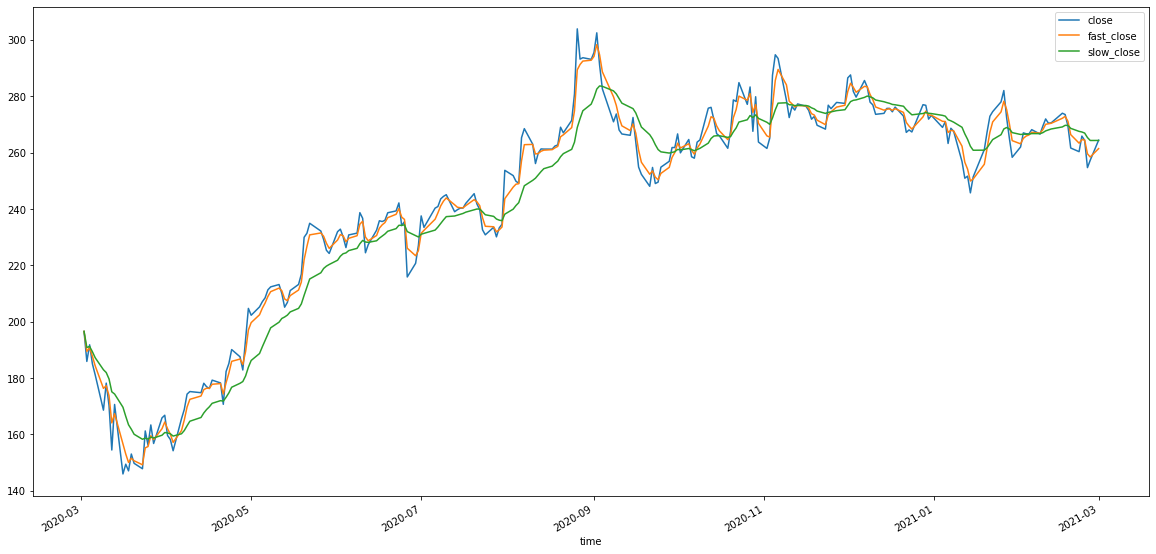

In [17]:
# Plot the EMA of closing prices
df[['close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

## Construct EMA on MACD

In [18]:
# short_window = 12
# long_window = 26
# signal_window = 9

# exp1 = df['close'].ewm(span=short_window, adjust=False).mean()
# exp2 = df['close'].ewm(span=long_window, adjust=False).mean()

# macd = exp1-exp2
# #print(macd)
# exp3 = macd.ewm(span=signal_window,adjust=False).mean()

# import matplotlib.pyplot as plt

# #show macd and signal
# plt.figure(figsize=(20,10))
# plt.plot(df.index, macd, label='MACD')
# plt.plot(df.index, exp3, label='Signal Line')
# plt.legend(loc='upper left')
# plt.show()

## Construct Signal on MACD

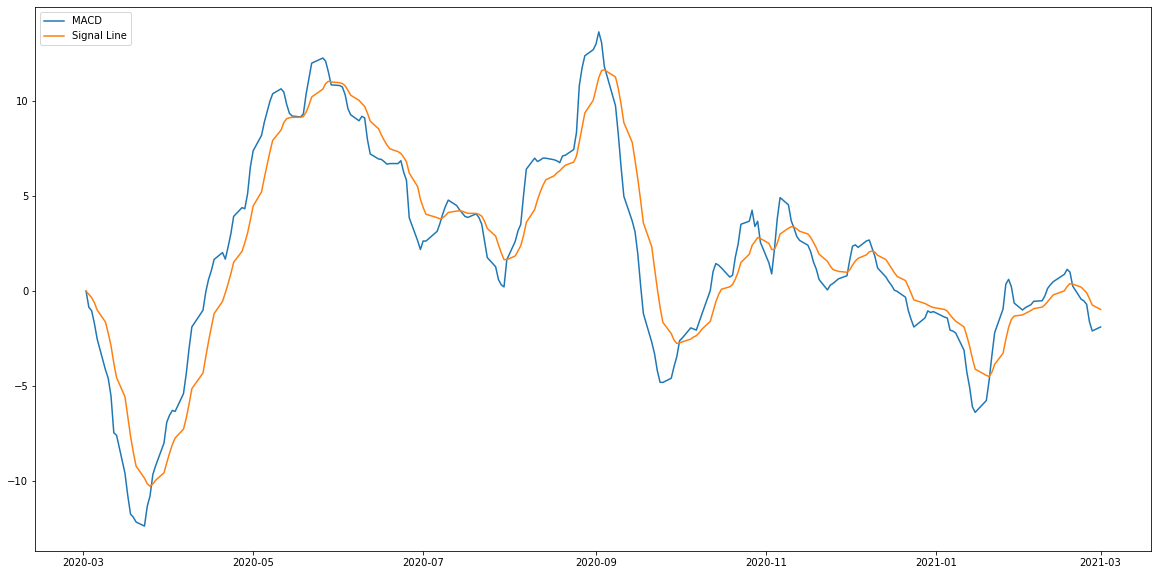

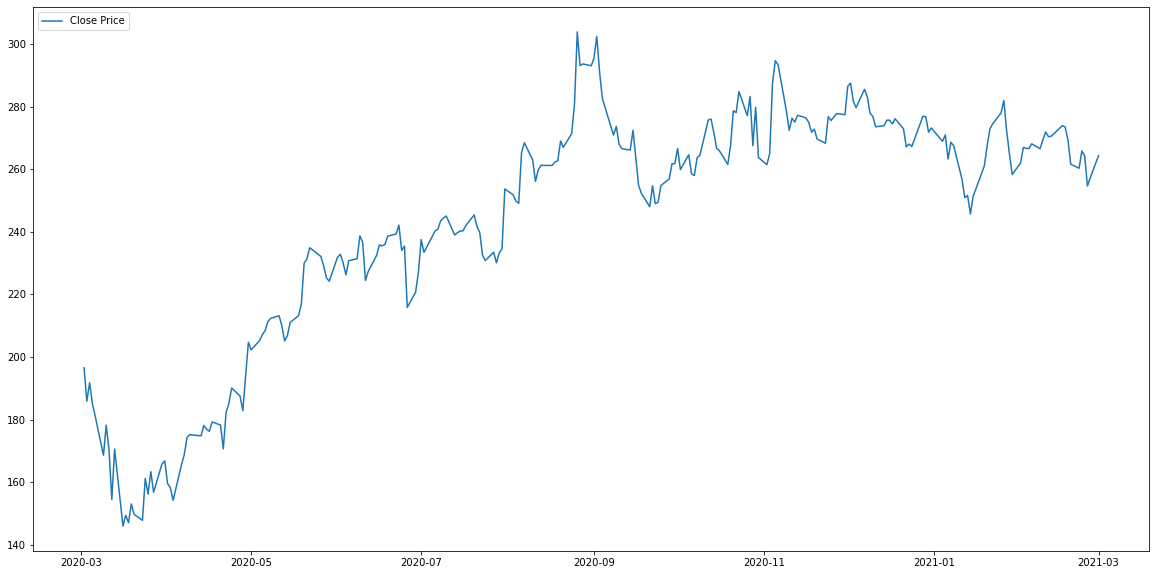

In [20]:
short_window = 12
long_window = 26
signal_window = 9

df['macd_short_window'] = df['close'].ewm(span=short_window,adjust=False).mean()
df['macd_long_window'] = df['close'].ewm(span=long_window,adjust=False).mean()
df['macd'] = df['macd_short_window'] - df['macd_long_window']
df['macd_signal'] = df['macd'].ewm(span=signal_window, adjust=False).mean()                      

df['macd_crossover_long'] = np.where(df['macd'] > df['macd_signal'],1.0,0.0)
df['macd_crossover_short'] = np.where(df['macd'] < df['macd_signal'],-1.0,0.0)
df['macd_crossover_signal'] = df['macd_crossover_long'] + df['macd_crossover_short']
df.head()

import matplotlib.pyplot as plt
#show macd and signal
plt.figure(figsize=(20,10))
plt.plot(df.index, df['macd'], label='MACD')
plt.plot(df.index, df['macd_signal'], label='Signal Line')
plt.legend(loc='upper left')
plt.show()

#show closing prices
plt.figure(figsize=(20,10))
plt.plot(df.index, df['close'], label='Close Price')
plt.legend(loc='upper left')
plt.show()



## Construct Signal on RSI

<AxesSubplot:xlabel='time'>

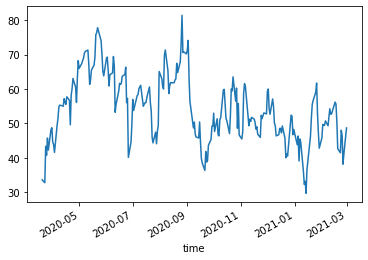

In [21]:
rsi_period = 14
chg = df['close'].diff(1)

gain = chg.copy()
loss = chg.copy()

gain[gain < 0] = 0
loss[loss > 0] = 0

avg_gain = gain.ewm(com=rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1,min_periods=rsi_period).mean()

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100/(1+rs))

df['rsi'] = rsi
df['rsi'].plot()

In [22]:
#logic on signal    
df['rsi_long'] = np.where(
            (df['rsi'] > 30) & (df['rsi'] < 70),
        1.0,0.0)

df['rsi_short'] = np.where(
            (df['rsi'] > 70),
        -1.0,0.0)

df['rsi_signal'] = df['rsi_long'] + df['rsi_short']


#### Drop NAs and Calculate Daily Returns

In [23]:
df['daily_return'] = df['close'].dropna().pct_change()
df.head()

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,...,macd_long_window,macd,macd_signal,macd_crossover_long,macd_crossover_short,macd_crossover_signal,rsi,rsi_long,rsi_short,rsi_signal
time,,,,,,,,,,,,,,,,,,,,,
2020-03-02 00:00:00-05:00,194.10,196.57,188.8500,196.54,21795546,NaN,196.540000,196.540000,0.0,0.0,...,196.540000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2020-03-03 00:00:00-05:00,196.22,197.24,183.9700,185.89,24693345,-0.054187,189.440000,190.846489,0.0,-1.0,...,195.751111,-0.849573,-0.169915,0.0,-1.0,-1.0,NaN,0.0,0.0,0.0
2020-03-04 00:00:00-05:00,189.05,191.83,186.3900,191.79,20486825,0.031739,190.782857,191.205456,0.0,-1.0,...,195.457695,-1.034855,-0.342903,0.0,-1.0,-1.0,NaN,0.0,0.0,0.0
2020-03-05 00:00:00-05:00,186.78,188.99,183.8901,185.02,21975861,-0.035299,187.709333,189.324328,0.0,-1.0,...,194.684533,-1.708283,-0.615979,0.0,-1.0,-1.0,NaN,0.0,0.0,0.0
2020-03-06 00:00:00-05:00,178.33,183.78,176.2600,181.11,21916170,-0.021133,184.303226,187.197647,0.0,-1.0,...,193.679012,-2.528339,-0.998451,0.0,-1.0,-1.0,NaN,0.0,0.0,0.0


## Construct EWM on Daily Returns Volatility

In [24]:
# Set short and long volatility windows
short_volatility_window = 1
long_volatility_window = 5

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_volatility'] = df['daily_return'].ewm(halflife=short_volatility_window).std()
df['slow_volatility'] = df['daily_return'].ewm(halflife=long_volatility_window).std()

# Construct a crossover trading signal
df['volatility_trend_long'] = np.where(df['fast_volatility'] < df['slow_volatility'], 1.0, 0.0)
df['volatility_trend_short'] = np.where(df['fast_volatility'] > df['slow_volatility'], -1.0, 0.0) 
df['volatility_trend_signal'] = df['volatility_trend_long'] + df['volatility_trend_short']

df.head()

,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,...,macd_crossover_signal,rsi,rsi_long,rsi_short,rsi_signal,fast_volatility,slow_volatility,volatility_trend_long,volatility_trend_short,volatility_trend_signal
time,,,,,,,,,,,,,,,,,,,,,
2020-03-02 00:00:00-05:00,194.10,196.57,188.8500,196.54,21795546,NaN,196.540000,196.540000,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2020-03-03 00:00:00-05:00,196.22,197.24,183.9700,185.89,24693345,-0.054187,189.440000,190.846489,0.0,-1.0,...,-1.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2020-03-04 00:00:00-05:00,189.05,191.83,186.3900,191.79,20486825,0.031739,190.782857,191.205456,0.0,-1.0,...,-1.0,NaN,0.0,0.0,0.0,0.060759,0.060759,0.0,-1.0,-1.0
2020-03-05 00:00:00-05:00,186.78,188.99,183.8901,185.02,21975861,-0.035299,187.709333,189.324328,0.0,-1.0,...,-1.0,NaN,0.0,0.0,0.0,0.043155,0.044480,1.0,0.0,1.0
2020-03-06 00:00:00-05:00,178.33,183.78,176.2600,181.11,21916170,-0.021133,184.303226,187.197647,0.0,-1.0,...,-1.0,NaN,0.0,0.0,0.0,0.028289,0.035038,1.0,0.0,1.0


In [25]:
df.index.name

'time'

In [26]:
df.reset_index(inplace=True)

In [27]:
df.head()

,time,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_long,...,macd_crossover_signal,rsi,rsi_long,rsi_short,rsi_signal,fast_volatility,slow_volatility,volatility_trend_long,volatility_trend_short,volatility_trend_signal
0,2020-03-02 00:00:00-05:00,194.10,196.57,188.8500,196.54,21795546,NaN,196.540000,196.540000,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,2020-03-03 00:00:00-05:00,196.22,197.24,183.9700,185.89,24693345,-0.054187,189.440000,190.846489,0.0,...,-1.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2020-03-04 00:00:00-05:00,189.05,191.83,186.3900,191.79,20486825,0.031739,190.782857,191.205456,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.060759,0.060759,0.0,-1.0,-1.0
3,2020-03-05 00:00:00-05:00,186.78,188.99,183.8901,185.02,21975861,-0.035299,187.709333,189.324328,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.043155,0.044480,1.0,0.0,1.0
4,2020-03-06 00:00:00-05:00,178.33,183.78,176.2600,181.11,21916170,-0.021133,184.303226,187.197647,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.028289,0.035038,1.0,0.0,1.0


In [28]:
df['time'] = df['time'].dt.date
df.head()

,time,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_long,...,macd_crossover_signal,rsi,rsi_long,rsi_short,rsi_signal,fast_volatility,slow_volatility,volatility_trend_long,volatility_trend_short,volatility_trend_signal
0,2020-03-02,194.10,196.57,188.8500,196.54,21795546,NaN,196.540000,196.540000,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,2020-03-03,196.22,197.24,183.9700,185.89,24693345,-0.054187,189.440000,190.846489,0.0,...,-1.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2020-03-04,189.05,191.83,186.3900,191.79,20486825,0.031739,190.782857,191.205456,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.060759,0.060759,0.0,-1.0,-1.0
3,2020-03-05,186.78,188.99,183.8901,185.02,21975861,-0.035299,187.709333,189.324328,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.043155,0.044480,1.0,0.0,1.0
4,2020-03-06,178.33,183.78,176.2600,181.11,21916170,-0.021133,184.303226,187.197647,0.0,...,-1.0,NaN,0.0,0.0,0.0,0.028289,0.035038,1.0,0.0,1.0


In [29]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df['bollinger_mid_band'] = df['close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 2)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 2)

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df['close'] < df['bollinger_lower_band'], 1.0, np.nan)
df['bollinger_short'] = np.where(df['close'] > df['bollinger_upper_band'], -1.0, np.nan)

df['bollinger_long'] = np.where(df['close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df['close'] > df['bollinger_upper_band'], -1.0, 0.0)

#df['bollinger_long'].fillna(1,method="ffill")
df['bollinger_long'].ffill(inplace=True)
df['bollinger_short'].ffill(inplace=True)

df.fillna(0.0,inplace=True)

df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']

df.head()

,time,open,high,low,close,volume,daily_return,fast_close,slow_close,crossover_long,...,volatility_trend_long,volatility_trend_short,volatility_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
0,2020-03-02,194.10,196.57,188.8500,196.54,21795546,0.000000,196.540000,196.540000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-03,196.22,197.24,183.9700,185.89,24693345,-0.054187,189.440000,190.846489,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-04,189.05,191.83,186.3900,191.79,20486825,0.031739,190.782857,191.205456,0.0,...,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-05,186.78,188.99,183.8901,185.02,21975861,-0.035299,187.709333,189.324328,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-06,178.33,183.78,176.2600,181.11,21916170,-0.021133,184.303226,187.197647,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

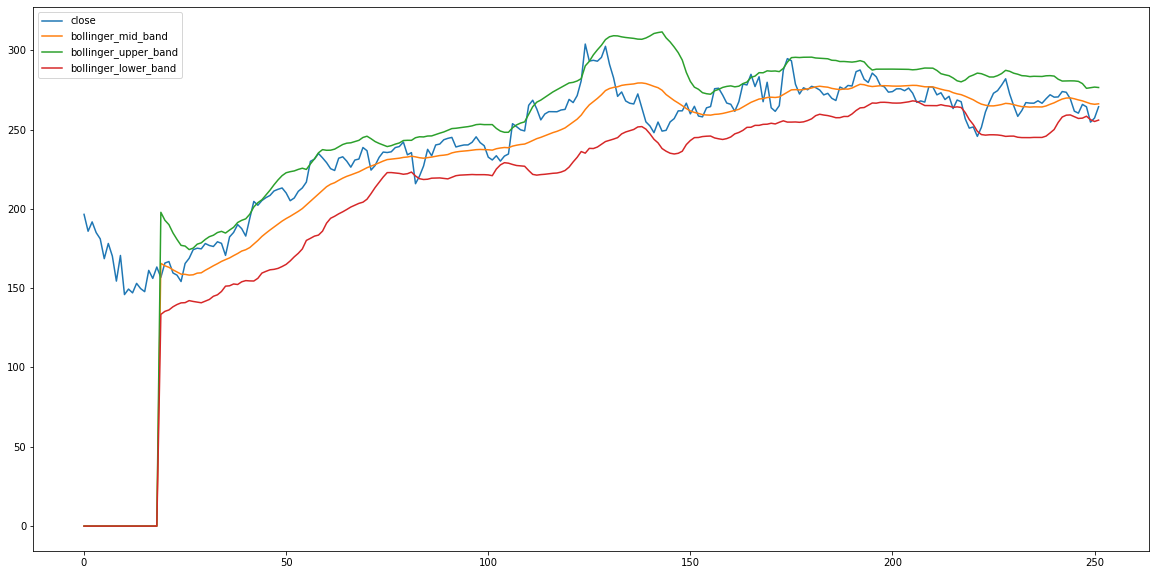

In [30]:
# Plot the Bollinger Bands for BTC/USD closing prices
df[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [32]:
df[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band', 'bollinger_signal']].head()

,close,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_signal
0,196.54,0.0,0.0,0.0,0.0
1,185.89,0.0,0.0,0.0,0.0
2,191.79,0.0,0.0,0.0,0.0
3,185.02,0.0,0.0,0.0,0.0
4,181.11,0.0,0.0,0.0,0.0


In [33]:
df.to_csv('trading_signals.csv')

In [34]:
df.index

RangeIndex(start=0, stop=252, step=1)